
The subject-wise shifts in starting point were correlated with the "left/right cue > neutral" cue-contrast to find subregions that show activity that is related to implementing response bias. After multiple-comparison correction, no correlation was significant.

In [115]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import scipy
import statsmodels.api as sm
import statsmodels
%matplotlib inline

In [116]:
all_betas = pd.read_pickle('./derivatives/STN_GLM_betavalues.pkl')
betas_cues = all_betas.loc[all_betas['event type'].isin(['cue_neutral', 'cue_payoff'])].set_index('subject')
betas_cues.head()

,event type,roi,beta,hemisphere,subregion
subject,,,,,
1,cue_payoff,signal_l_A,0.405325,l,A
1,cue_neutral,signal_l_A,0.256683,l,A
2,cue_payoff,signal_l_A,-0.228669,l,A
2,cue_neutral,signal_l_A,-0.173208,l,A
3,cue_payoff,signal_l_A,0.116644,l,A


#### calculate contrast payoff - neutral

In [117]:
def get_contrast(x):
    return pd.Series({'contrast': x.loc[x['event type'] == 'cue_payoff', 'beta'].values[0] - x.loc[x['event type'] == 'cue_neutral', 'beta'].values[0]})

beta_contrast = betas_cues.groupby(['subject', 'roi'])[['event type', 'beta']].apply(get_contrast)

#### zscore within dataset

In [118]:
beta_contrast = beta_contrast.reset_index()
beta_contrast['dataset'] = np.hstack([np.repeat(['ds-01'], 19*6), np.repeat(['ds-02'], 14*6)])
contrast_zscored = beta_contrast.groupby(['dataset'])['contrast'].apply(lambda x: (x-x.mean())/x.std())
beta_contrast['contrast_zscored'] = contrast_zscored
beta_contrast.head()

,subject,roi,contrast,dataset,contrast_zscored
0,1,signal_l_A,0.148641,ds-01,0.610767
1,1,signal_l_B,0.209342,ds-01,0.974539
2,1,signal_l_C,0.166442,ds-01,0.717443
3,1,signal_r_A,0.033935,ds-01,-0.076653
4,1,signal_r_B,0.102775,ds-01,0.335896


## Load parameters, merge with betas 

In [119]:
all_params = pd.read_csv('./derivatives/BMAParameters.csv', index_col=0)
all_params.index.name = 'subject'

all_params['dataset'] = ['ds-01'] * 19 + ['ds-02'] * 14
all_params['zshiftBias_zscored'] = all_params.groupby('dataset')['zshiftBias'].apply(lambda x: (x-x.mean())/x.std())
all_params['vshift_zscored'] = all_params.groupby('dataset')['vshift'].apply(lambda x: (x-x.mean())/x.std())
all_params['vshiftBias_zscored'] = all_params.groupby('dataset')['vshiftBias'].apply(lambda x: (x-x.mean())/x.std())

In [120]:
combined_data = pd.merge(beta_contrast, all_params, on=['subject', 'dataset'])
combined_data['hemisphere'] = combined_data['roi'].str.split('_').apply(lambda x: x[1])
combined_data['subregion'] = combined_data['roi'].str.split('_').apply(lambda x: x[2])
combined_data.head()

,subject,roi,contrast,dataset,contrast_zscored,a,v.low,v.high,z,zshiftBias,vshift,vshiftBias,t0,zshiftBias_zscored,vshift_zscored,vshiftBias_zscored,hemisphere,subregion
0,1,signal_l_A,0.148641,ds-01,0.610767,1.342808,0.206951,0.719987,0.450266,0.025863,0.513035,-0.143251,0.457337,0.095806,0.342131,-0.922127,l,A
1,1,signal_l_B,0.209342,ds-01,0.974539,1.342808,0.206951,0.719987,0.450266,0.025863,0.513035,-0.143251,0.457337,0.095806,0.342131,-0.922127,l,B
2,1,signal_l_C,0.166442,ds-01,0.717443,1.342808,0.206951,0.719987,0.450266,0.025863,0.513035,-0.143251,0.457337,0.095806,0.342131,-0.922127,l,C
3,1,signal_r_A,0.033935,ds-01,-0.076653,1.342808,0.206951,0.719987,0.450266,0.025863,0.513035,-0.143251,0.457337,0.095806,0.342131,-0.922127,r,A
4,1,signal_r_B,0.102775,ds-01,0.335896,1.342808,0.206951,0.719987,0.450266,0.025863,0.513035,-0.143251,0.457337,0.095806,0.342131,-0.922127,r,B


Text(0.5, 0, 'Start point shift (z-scored)')

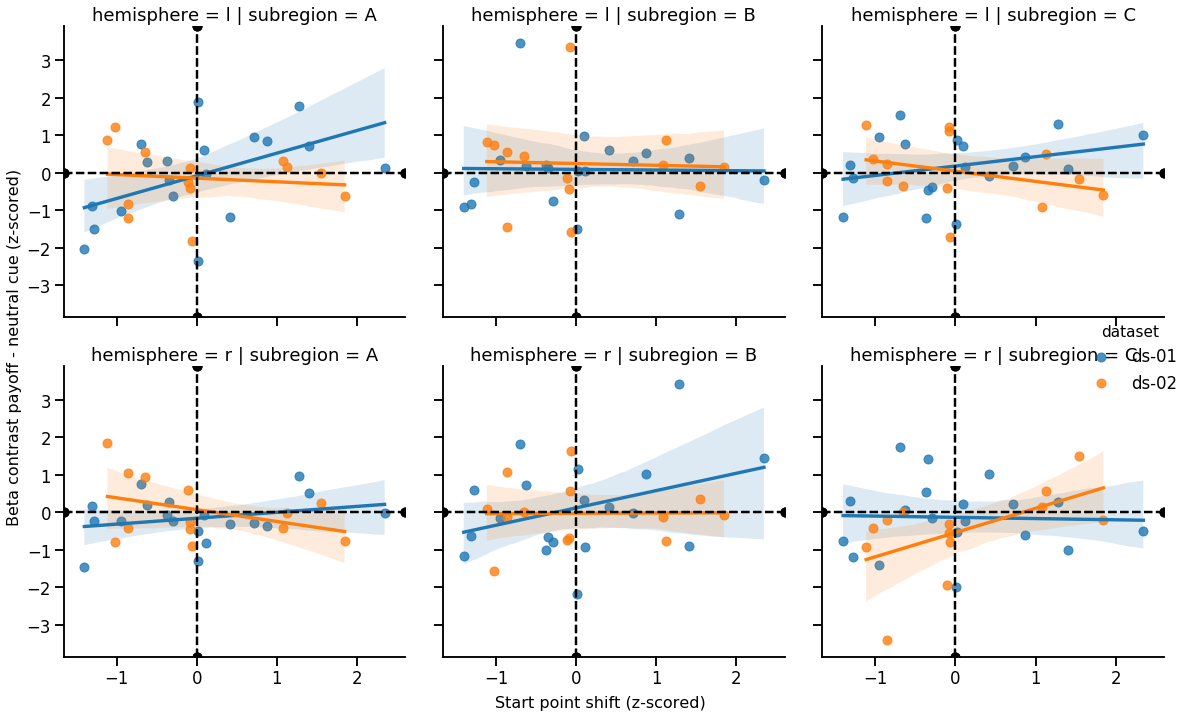

In [121]:
sns.set_context('talk')
fac = sns.lmplot(x='zshiftBias_zscored',
                 y='contrast_zscored', data=combined_data, 
                 row='hemisphere', col='subregion', hue='dataset', truncate=True)

fac.map(plt.axhline, y=0, c='k', ls='--')
fac.map(plt.axvline, x=0, c='k', ls='--')

fac.fig.text(x=0, y=0.5, 
           verticalalignment='center', #make sure it's aligned at center vertically
           s='Beta contrast payoff - neutral cue (z-scored)', #this is the text in the ylabel
           size=16, #customize the fontsize if you will
           rotation=90) #vertical text

#overall xlabel
fac.fig.text(x=0.5, y=0, 
             horizontalalignment='center', #make sure it's aligned at center horizontally
             s='Start point shift (z-scored)', #this is the text in the xlabel
             size=16)

In [122]:
# correlation estimates
results = []
for roi in combined_data.roi.unique():
    print(roi)
    r, p = scipy.stats.pearsonr(combined_data.loc[(combined_data.roi==roi), 'contrast_zscored'], 
                                combined_data.loc[(combined_data.roi==roi), 'zshiftBias'])
    results.append({'mask': roi, 'r':r, 'p':p})
    
results = pd.DataFrame(results)
_, p_fdr, _, _ = statsmodels.stats.multitest.multipletests(results['p'], method='fdr_bh')
results['p.fdr'] = p_fdr
results

signal_l_A
signal_l_B
signal_l_C
signal_r_A
signal_r_B
signal_r_C


,mask,p,r,p.fdr
0,signal_l_A,0.110743,0.287385,0.664455
1,signal_l_B,0.973052,-0.006219,0.996674
2,signal_l_C,0.901713,0.022733,0.996674
3,signal_r_A,0.996674,-0.000768,0.996674
4,signal_r_B,0.223248,0.221428,0.669743
5,signal_r_C,0.361840,0.166697,0.723681


In [123]:
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [124]:
combined_data.head()

,subject,roi,contrast,dataset,contrast_zscored,a,v.low,v.high,z,zshiftBias,vshift,vshiftBias,t0,zshiftBias_zscored,vshift_zscored,vshiftBias_zscored,hemisphere,subregion
0,1,signal_l_A,0.148641,ds-01,0.610767,1.342808,0.206951,0.719987,0.450266,0.025863,0.513035,-0.143251,0.457337,0.095806,0.342131,-0.922127,l,A
1,1,signal_l_B,0.209342,ds-01,0.974539,1.342808,0.206951,0.719987,0.450266,0.025863,0.513035,-0.143251,0.457337,0.095806,0.342131,-0.922127,l,B
2,1,signal_l_C,0.166442,ds-01,0.717443,1.342808,0.206951,0.719987,0.450266,0.025863,0.513035,-0.143251,0.457337,0.095806,0.342131,-0.922127,l,C
3,1,signal_r_A,0.033935,ds-01,-0.076653,1.342808,0.206951,0.719987,0.450266,0.025863,0.513035,-0.143251,0.457337,0.095806,0.342131,-0.922127,r,A
4,1,signal_r_B,0.102775,ds-01,0.335896,1.342808,0.206951,0.719987,0.450266,0.025863,0.513035,-0.143251,0.457337,0.095806,0.342131,-0.922127,r,B


In [155]:
%%R -i combined_data
library(BayesFactor)

combined_data$hemisphere <- factor(combined_data$hemisphere)
combined_data$subregion <- factor(combined_data$subregion)
combined_data$dataset <- factor(combined_data$dataset)
combined_data$subject <- factor(combined_data$subject)

bf1 = lmBF(zshiftBias ~ 1 + dataset, data = combined_data, whichRandom='subject')
bf2 = lmBF(zshiftBias ~ 1 + contrast + dataset, data = combined_data, whichRandom='subject')
bf3 = lmBF(zshiftBias ~ 1 + contrast*subregion + dataset, data = combined_data, whichRandom='subject')
print(bf1)         # BF10 = 174.863 --> strong evidence for an effect of dataset on zshifts
print(bf2/bf1)     # BF21 = 0.70864 --> anecdotal evidence against a correlation
print(bf3/bf2)     # BF32 = 0.0036252 --> strong evidence against any differences in correlations between subregions

Bayes factor analysis
--------------
[1] 1 + dataset : 174.863 ±0%

Against denominator:
  Intercept only 
---
Bayes factor type: BFlinearModel, JZS

Bayes factor analysis
--------------
[1] 1 + contrast + dataset : 0.7078296 ±0.83%

Against denominator:
  zshiftBias ~ 1 + dataset 
---
Bayes factor type: BFlinearModel, JZS

Bayes factor analysis
--------------
[1] 1 + contrast * subregion + dataset : 0.003444019 ±3.39%

Against denominator:
  zshiftBias ~ 1 + contrast + dataset 
---
Bayes factor type: BFlinearModel, JZS



## Evidence against correlations, evidence against any difference between hemispheres, evidence against any difference between subregions

# Easy vs hard?

In [128]:
betas_easyhard = all_betas.loc[all_betas['event type'].isin(['easy', 'hard'])]

def get_contrast(x):
    return pd.Series({'contrast': x.loc[x['event type'] == 'hard', 'beta'].values[0] - x.loc[x['event type'] == 'easy', 'beta'].values[0]})

beta_contrast = betas_easyhard.groupby(['subject', 'roi'])[['event type', 'beta']].apply(get_contrast)

beta_contrast = beta_contrast.reset_index()
beta_contrast['dataset'] = np.hstack([np.repeat(['ds-01'], 19*6), np.repeat(['ds-02'], 14*6)])
contrast_zscored = beta_contrast.groupby(['dataset'])['contrast'].apply(lambda x: (x-x.mean())/x.std())
beta_contrast['contrast_zscored'] = contrast_zscored
beta_contrast.head()

,subject,roi,contrast,dataset,contrast_zscored
0,1,signal_l_A,0.013394,ds-01,0.188676
1,1,signal_l_B,-0.210553,ds-01,-1.291076
2,1,signal_l_C,-0.338578,ds-01,-2.137019
3,1,signal_r_A,-0.054502,ds-01,-0.259955
4,1,signal_r_B,-0.040659,ds-01,-0.168484


In [144]:
combined_data = pd.merge(beta_contrast.reset_index(), all_params, on=['subject', 'dataset'])
combined_data['hemisphere'] = combined_data['roi'].str.split('_').apply(lambda x: x[1])
combined_data['subregion'] = combined_data['roi'].str.split('_').apply(lambda x: x[2])

Text(0.5, 0, 'Drift rate change (z-scored)')

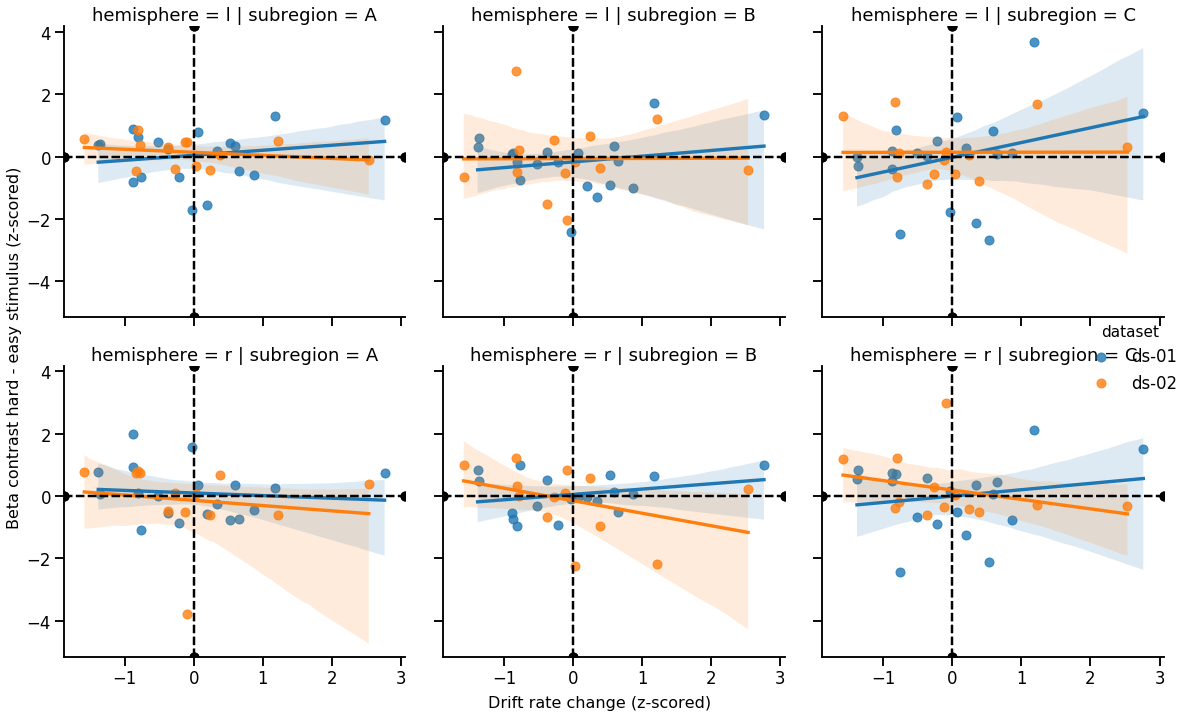

In [145]:
fac = sns.lmplot(x='vshift_zscored',
                 y='contrast_zscored', data=combined_data, 
                 row='hemisphere', col='subregion', hue='dataset', truncate=True)

fac.map(plt.axhline, y=0, c='k', ls='--')
fac.map(plt.axvline, x=0, c='k', ls='--')

fac.fig.text(x=0, y=0.5, 
           verticalalignment='center', #make sure it's aligned at center vertically
           s='Beta contrast hard - easy stimulus (z-scored)', #this is the text in the ylabel
           size=16, #customize the fontsize if you will
           rotation=90) #vertical text

#overall xlabel
fac.fig.text(x=0.5, y=0, 
             horizontalalignment='center', #make sure it's aligned at center horizontally
             s='Drift rate change (z-scored)', #this is the text in the xlabel
             size=16)

In [146]:
# correlation estimates
results = []
for roi in combined_data.roi.unique():
    print(roi)
    r, p = scipy.stats.pearsonr(combined_data.loc[(combined_data.roi==roi), 'contrast_zscored'], 
                                combined_data.loc[(combined_data.roi==roi), 'vshift_zscored'])
    results.append({'mask': roi, 'r':r, 'p':p})
    
results = pd.DataFrame(results)
_, p_fdr, _, _ = statsmodels.stats.multitest.multipletests(results['p'], method='fdr_bh')
results['p.fdr'] = p_fdr
results

signal_l_A
signal_l_B
signal_l_C
signal_r_A
signal_r_B
signal_r_C


,mask,p,r,p.fdr
0,signal_l_A,0.687026,0.074071,0.824431
1,signal_l_B,0.570959,0.104035,0.824431
2,signal_l_C,0.234665,0.216192,0.824431
3,signal_r_A,0.525759,-0.116413,0.824431
4,signal_r_B,0.675091,-0.077055,0.824431
5,signal_r_C,0.967097,-0.007594,0.967097


In [149]:
combined_data.head()

,index,subject,roi,contrast,dataset,contrast_zscored,a,v.low,v.high,z,zshiftBias,vshift,vshiftBias,t0,zshiftBias_zscored,vshift_zscored,vshiftBias_zscored,hemisphere,subregion
0,0,1,signal_l_A,0.013394,ds-01,0.188676,1.342808,0.206951,0.719987,0.450266,0.025863,0.513035,-0.143251,0.457337,0.095806,0.342131,-0.922127,l,A
1,1,1,signal_l_B,-0.210553,ds-01,-1.291076,1.342808,0.206951,0.719987,0.450266,0.025863,0.513035,-0.143251,0.457337,0.095806,0.342131,-0.922127,l,B
2,2,1,signal_l_C,-0.338578,ds-01,-2.137019,1.342808,0.206951,0.719987,0.450266,0.025863,0.513035,-0.143251,0.457337,0.095806,0.342131,-0.922127,l,C
3,3,1,signal_r_A,-0.054502,ds-01,-0.259955,1.342808,0.206951,0.719987,0.450266,0.025863,0.513035,-0.143251,0.457337,0.095806,0.342131,-0.922127,r,A
4,4,1,signal_r_B,-0.040659,ds-01,-0.168484,1.342808,0.206951,0.719987,0.450266,0.025863,0.513035,-0.143251,0.457337,0.095806,0.342131,-0.922127,r,B


In [156]:
%%R -i combined_data
library(BayesFactor)

combined_data$hemisphere <- factor(combined_data$hemisphere)
combined_data$subregion <- factor(combined_data$subregion)
combined_data$dataset <- factor(combined_data$dataset)
combined_data$subject <- factor(combined_data$subject)

bf1 = lmBF(vshift ~ 1 + dataset, data = combined_data, whichRandom='subject')
bf2 = lmBF(vshift ~ 1 + contrast + dataset, data = combined_data, whichRandom='subject')
bf3 = lmBF(vshift ~ 1 + contrast*subregion + dataset, data = combined_data, whichRandom='subject')
print(bf1)         # BF10 = 3.78*10^16 --> decisive evidence for an effect of dataset on vshifts
print(bf2/bf1)     # BF21 = 0.1704103 --> strong evidence against a correlation between zshifts and beta contrasts
print(bf3/bf2)     # BF32 = 0.004387895 --> decisive evidence against any differences in correlations between subregions

Bayes factor analysis
--------------
[1] 1 + dataset : 3.79711e+16 ±0%

Against denominator:
  Intercept only 
---
Bayes factor type: BFlinearModel, JZS

Bayes factor analysis
--------------
[1] 1 + contrast + dataset : 0.1704103 ±1.1%

Against denominator:
  vshift ~ 1 + dataset 
---
Bayes factor type: BFlinearModel, JZS

Bayes factor analysis
--------------
[1] 1 + contrast * subregion + dataset : 0.004387895 ±3.81%

Against denominator:
  vshift ~ 1 + contrast + dataset 
---
Bayes factor type: BFlinearModel, JZS



## Again, evidence against differences between subregions